<font color='darkblue' size=6>
Thompson sampling with linear payoff - Simulate </font>



# References 

https://www.youtube.com/watch?v=7F0jPUyb7m4


*Slide from Shipra Shukla's Linear contextual bandits for sequential decision making presention 2019*
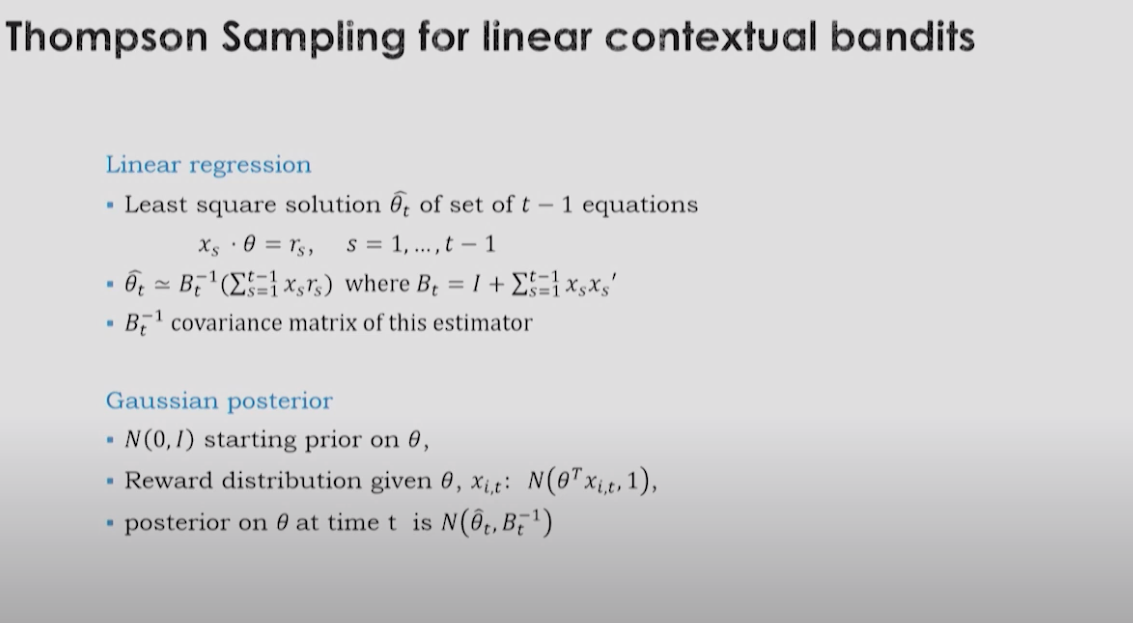

https://arxiv.org/pdf/1209.3352.pdf



------------------------------------------
**Derive Mean and Variance of Linear OLS Estimators in Matrix Form**

https://youtu.be/bUG9T9dvLlY



------------------------------------------
**Matrix derivations for mean and covariance estimates AND ridge regression (lambda)**

https://arxiv.org/pdf/1509.09169.pdf



------------------------------------------


**Unbiased\ variance\ estimate**

2.7 Estimating the Variance of the Error Term - "Principles of Econometrics - William Griffiths
http://repositorii.urindo.ac.id/repository2/files/original/112377a4f88699ef6d0e6a0a9fc7150b2811c4f5.pdf

$unbiasedErrorVariance\ Noise \ {\sigma^2}$ = $ var({\epsilon}) $ = ${E(err_i - E(err_i))}^2 $  

$Since\ {E(err_i)} =0 ,$ 

$unbiasedErrorVariance\ Noise \ {\sigma^2} = var({\epsilon}) $ = $ {E(err_i)}^2$    = $ np.dot( (y - y^{hat})^T * (y - y^{hat}) ) / (N- p) $


------------------------------------------



**Scaled Down Unbiased variance estimate**

$ Scaled Down Unbiased\ variance\ estimate = scaling\_down\_factor * var({\epsilon}) $


------------------------------------------

**What does other literature say?** 

-- Bayesian Bandit Showdown (NN + linear TS)


https://arxiv.org/abs/1802.09127

https://openreview.net/pdf?id=SyYe6k-CW



------------------------------------------

**Other references **

https://github.com/jonnedtc/Multi-Armed-Bandits/blob/master/Bandits.py

https://github.com/ntucllab/striatum/blob/master/striatum/bandit/linthompsamp.py


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import pickle
import sklearn
import scipy
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import yaml
import random
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

In [3]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.width',500)
sns.set()
tqdm.pandas()

/home/ubuntu/anaconda3/envs/ranking_prodAPI/lib/python3.8/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Test create offline data 

## Assume mean and covariance matrices

In [4]:
mu_vec = np.array([[1   , 0.1 ,  1 ,0.01  ],
                   [1.25, 0.3 ,0.5 ,0.015 ],
                   [1.5 , 0.5 ,0.1 ,0.01  ],
                   [1.75, 0.3 ,0.5 ,0.015 ],
                   [2.0 , 0.1 ,  1 ,0.01  ] ])
mu_vec

array([[1.   , 0.1  , 1.   , 0.01 ],
       [1.25 , 0.3  , 0.5  , 0.015],
       [1.5  , 0.5  , 0.1  , 0.01 ],
       [1.75 , 0.3  , 0.5  , 0.015],
       [2.   , 0.1  , 1.   , 0.01 ]])

In [5]:
num_arms   = 5
matrixSize = 4
parmCovMat = []

for i in range(num_arms):
    _tempA  = np.random.rand(1000, matrixSize)
    pCovMat = np.dot(_tempA.transpose(), _tempA) #To get a positive definite matrix
    pCovMat = pCovMat/2000 #To reduce the scale of variances and covariances. 
    pCovMat +=np.ones((matrixSize, matrixSize)) * np.array([[0.0, -0.1,-0.1, 0.0],
                                                            [-0.1, 0.0,-0.1, 0.0],
                                                            [-0.1,-0.1, 0.0, 0.0],
                                                            [ 0.0, 0.0, 0.0, 0.0]]) # To increase the variances [as in ridge regression] i.e. implying lower covariances between parameters
    pCovMat[matrixSize-1,:] = 0.0
    pCovMat[:,matrixSize-1] = 0.0
    pCovMat[matrixSize-1,matrixSize-1] = 0.005
    parmCovMat.append(pCovMat)

#     pCovMat +=np.ones((matrixSize, matrixSize)) * np.array([[0.2, -0.05, 0.05],
#                                                             [-0.05, 0.5, 0.0],
#                                                             [-0.05, 0.0, 0.5]]) # To increase the variances [as in ridge regression] i.e. implying lower covariances between parameters
parmCovMat

[array([[0.17292525, 0.02823662, 0.02794717, 0.        ],
        [0.02823662, 0.16640056, 0.02439117, 0.        ],
        [0.02794717, 0.02439117, 0.16718769, 0.        ],
        [0.        , 0.        , 0.        , 0.005     ]]),
 array([[0.1712594 , 0.02371362, 0.02910476, 0.        ],
        [0.02371362, 0.15878874, 0.02199926, 0.        ],
        [0.02910476, 0.02199926, 0.17266137, 0.        ],
        [0.        , 0.        , 0.        , 0.005     ]]),
 array([[0.16578327, 0.03053985, 0.02798223, 0.        ],
        [0.03053985, 0.17533346, 0.0318413 , 0.        ],
        [0.02798223, 0.0318413 , 0.17013311, 0.        ],
        [0.        , 0.        , 0.        , 0.005     ]]),
 array([[0.1654775 , 0.02511613, 0.02571336, 0.        ],
        [0.02511613, 0.16694934, 0.02543592, 0.        ],
        [0.02571336, 0.02543592, 0.16614152, 0.        ],
        [0.        , 0.        , 0.        , 0.005     ]]),
 array([[0.16874394, 0.02708303, 0.02603373, 0.        ],
      

## Create a big batch of data. 

## Instead of fixed table, you could wrap new data generation within a function

In [6]:
X_mumat  = np.array([5, 5])
X_covmat = np.array([[5, 2],
                      [2 ,5]]) #2 variables

datarows = 10000
X_matrix     = np.random.multivariate_normal(mean= X_mumat, cov= X_covmat, size=datarows, check_valid='warn', tol=1e-8)
sampled_data = np.hstack((np.ones([datarows,1]), X_matrix, np.expand_dims(X_matrix[:, 0] * X_matrix[:, 1], axis=1) ) )


In [7]:
sampled_data.shape

(10000, 4)

In [8]:
sampled_data, sampled_data.mean(axis=0)

(array([[ 1.        ,  8.2186735 ,  6.78254595, 55.74353067],
        [ 1.        ,  7.32514859,  7.57530131, 55.49020774],
        [ 1.        ,  0.69389805,  5.18606605,  3.59860111],
        ...,
        [ 1.        ,  2.12825711,  6.0248328 , 12.82239327],
        [ 1.        ,  2.60829466,  5.60370476, 14.61611317],
        [ 1.        ,  8.30092888,  7.1112037 , 59.02959611]]),
 array([ 1.        ,  4.99527853,  4.97311239, 26.85762365]))

In [9]:
import sklearn
from sklearn.linear_model import LinearRegression

In [10]:
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm



In [11]:
from scipy.stats import invgamma
import copy


<font color='darkblue' size=7 > online learning </font>

<font color='darkblue' size=4> blackbox spitting out reward given action as input </font>

In [16]:
ERROR_VARIANCE_STD = 5
def sampled_parm(act:int=0, size=1):
    # mu_vec, parmCovMat  
    return np.random.multivariate_normal(mean= mu_vec[act], cov= parmCovMat[act], size=size, check_valid='warn', tol=1e-8)

def yourORG_as_a_blackBox(d, rec_actions):
    rewards_given_action = []
    for i, r in enumerate(d):
        parm    = sampled_parm(act=rec_actions[i], size=1)
        reward  = np.dot(parm , np.transpose(r)[..., np.newaxis]).ravel()
        err     = np.random.normal(loc=0, scale=ERROR_VARIANCE_STD, size=1)
        reward +=err
        rewards_given_action.append([np.asscalar(reward)])
    return np.array(rewards_given_action)
    

In [17]:
class LinearPosteriorSampling():
    """
    Simple linear sampler
    """
    def __init__(self, num_features, num_actions, sigmultiplier= 'fixed', diagmat =False, scaled_down_error_variance= 0.1, R=0.5):

        #self.hparams       = hparams
        self.num_features  = num_features
        self.num_actions   = num_actions
        
        self.diagmat       = diagmat
        self.sigmultiplier = sigmultiplier

        self.scaled_down_error_variance = scaled_down_error_variance

        # 
        self._lambda_prior = 0.0001 #almost zero, i.e. NOT used here. It can be set to higher value to bolster like a ridge regression 

        self.mu  = [ np.zeros(self.num_features)
                                        for _ in range(self.num_actions) ]

        self.cov = [(1.0 / self._lambda_prior) * np.eye(self.num_features)
                                        for _ in range(self.num_actions)]

        self.precision = [self._lambda_prior * np.eye(self.num_features)
                                        for _ in range(self.num_actions) ]
        
        self.R       = R
        self.epsilon = 0.1
        self.delta   = 0.5
        self.t       = 1
        
        self.sig_sq = self.R * np.sqrt((24 / self.epsilon) * self.num_features * np.log(self.t / self.delta))
        
        if self.sigmultiplier =='fixed':
             self.sig_sq_2 = [self.sig_sq  for _ in range(self.num_actions) ]
        elif (self.sigmultiplier =='unbiased_error_variance') or (self.sigmultiplier =='scaled_down_error_variance'):
             self.sig_sq_2 = [0.01  for _ in range(self.num_actions) ]

        self.t = 0
        self.data_cumulative = {}
        for i in range(self.num_actions):
            self.data_cumulative[i] = {'context': np.array([]) , 
                                        'reward': np.array([])}
            
        self.sig_sq_2_BKP_list = []

    def update_offline_data(self, context, action, reward):
        for i in range(self.num_actions):
            if len(self.data_cumulative[i]['context'])==0:
                self.data_cumulative[i]['context'] = copy.deepcopy(context[(action==i).ravel(),:]) 
                self.data_cumulative[i]['reward']  = copy.deepcopy(reward[(action==i).ravel(),:]) 
            else:
                self.data_cumulative[i]['context'] =  np.vstack((self.data_cumulative[i]['context'], context[(action==i).ravel(),:])) 
                self.data_cumulative[i]['reward']  =  np.vstack((self.data_cumulative[i]['reward'] , reward[(action==i).ravel(),:])) 
                
    def yourAPI_recommending_actions(self, mdlidx , context, size=1):
        if mdlidx ==1: #random
            if size==1:
                return np.random.choice(np.arange(self.num_actions), size=size)[0]
            else:
                return np.random.choice(np.arange(self.num_actions), size=size)
        elif mdlidx ==2: #Linear TS
            return self.recommend_action(context)

    def recommend_action(self, context):
        """Samples beta's from posterior, and chooses best action accordingly."""

        try:
            if self.diagmat ==False:
                beta_s = [ np.random.multivariate_normal(self.mu[i], self.sig_sq_2[i] * self.cov[i]) 
                                         for i in range(self.num_actions) ]
            else:
                beta_s = [ np.random.multivariate_normal(self.mu[i], self.sig_sq_2[i] * (np.diag(self.cov[i]) * np.eye(self.num_features)) ) 
                                         for i in range(self.num_actions) ]
                
        except np.linalg.LinAlgError as e:
            # Sampling could fail if covariance is not positive definite
            print('Exception when sampling for {}.'.format(self.name))
            print('Details: {} | {}.'.format(e.message, e.args))
            beta_s = [ np.random.multivariate_normal(np.zeros((self.num_features)), np.eye(self.num_features))
                                           for i in range(self.num_actions) ]

        # Compute expected reward, given context and action, using sampled parameter vector
        vals = [ np.dot(beta_s[i], context.T) for i in range(self.num_actions) ]
        return np.argmax(vals,axis=0)

    def update(self, context, action, reward):
        """Update regression coefficients """

        self.t += 1
        self.update_offline_data(context, action, reward)

        # Update the  Linear Regression
        for action_v in range(self.num_actions):
            # retrieve data for one action/arm at a time
            z, y = self.data_cumulative[action_v]['context'], self.data_cumulative[action_v]['reward']  

            # x`x
            s = np.dot(z.T, z)
            
            precision_a = s + self.lambda_prior * np.eye(self.num_features)
            #precision_a = s 
            cov_a       = np.linalg.inv(precision_a)
            mu_a        = np.dot(cov_a, np.dot(z.T, y)).ravel()

            # Store mean and covariance matrices of the parameters
            self.mu[action_v]        = mu_a
            self.cov[action_v]       = cov_a
            self.precision[action_v] = precision_a

            #unbiased error variance
            y_hat                   = np.dot(z, mu_a).ravel()
            err                     = y.ravel() - y_hat
            sig_sq_2                = np.dot(err.T, err) /(z.shape[0] - len(mu_a.ravel())) #unbiased_error_variance

            if self.sigmultiplier =='fixed':
                pass #
            elif self.sigmultiplier =='unbiased_error_variance':
                self.sig_sq_2[action_v] = sig_sq_2
            elif self.sigmultiplier =='scaled_down_error_variance':
                self.sig_sq_2[action_v] = self.scaled_down_error_variance * sig_sq_2

            self.sig_sq_2_BKP_list.append([self.t, action_v, z.shape[0], self.sig_sq_2[action_v] , self.sig_sq_2[i] * np.diag(self.cov[i]) ])


<font color='darkblue' size=4 > Training </font>

In [18]:
class training_module():
    def __init__(self, sampled_data, num_features=4, num_actions=5, sigmultiplier= 'fixed', diagmat =False, scaled_down_error_variance= 0.1, R=0.5, knownfeatures=0):
        #
        self.lp             = LinearPosteriorSampling(num_features=4, num_actions=5, sigmultiplier= 'fixed', diagmat =False, scaled_down_error_variance= 0.1, R=0.5)
        self.sampled_data   = sampled_data
        self.num_features   = num_features
        if isinstance(knownfeatures, np.ndarray ) or np.isscalar(knownfeatures):
            self.knownfeatures  = knownfeatures
        else:
            assert 0==1, 'Either pass a scalar in knownfeatures OR pass numpy array indices of columns that should be used in the feature set'
            
    def run_each_batch(self, btchsize, mdlidx=1):
        orgtrf_idx                    = np.random.choice(np.arange(len(self.sampled_data)), size= btchsize, replace=False,) #d[btchidx]
        if isinstance(self.knownfeatures, np.ndarray ):
             orgtraffic_known_features     = self.sampled_data[orgtrf_idx, :][:,self.knownfeatures]
        else:
             orgtraffic_known_features     = self.sampled_data[orgtrf_idx]
        orgtraffic_w_unknown_features = self.sampled_data[orgtrf_idx]
        rec_actions                   = self.lp.yourAPI_recommending_actions(mdlidx, context = orgtraffic_known_features, size=len(orgtraffic_known_features))

        rewards_seen_in_data          = yourORG_as_a_blackBox(orgtraffic_w_unknown_features, rec_actions)
        return orgtraffic_known_features, rec_actions[..., np.newaxis], rewards_seen_in_data

    def training_routine(self, btchsize, num_batches):
        batchnum  = 0
        #BATCHSIZE = btchsize
        d, a, r   = self.run_each_batch(btchsize= btchsize, mdlidx =1) # random selection of actions
            
        #update offline stacked data in lp object with new data, re-estimate regression coefficients (batch 0)
        self.lp.update(d, a, r)

        #batch 1 to N - explore exploit, update parameters
        reward_sum_list = [] 
        reward_sum_list.append([batchnum, r.ravel().mean(), r.ravel().sum()])
        for batchnum in range(1, num_batches): 
               #explore exploit
               d, a, r   = self.run_each_batch(btchsize= btchsize, mdlidx =2) 
               reward_sum_list.append([batchnum, r.ravel().mean(), r.ravel().sum()])
               #update offline stacked data in lp object with new data, re-estimate regression coefficients
               self.lp.update(d, a, r)

        dfres = pd.DataFrame(reward_sum_list, columns = ['batchnum','mean_reward','sum_reward'])

        variance_parms = pd.DataFrame(self.lp.sig_sq_2_BKP_list, columns=['iter','act','N', 'sig_square', 'sig_cov_prod' ])

        self.dfres          = dfres
        self.variance_parms = variance_parms



<font color='darkblue' size=6> Simulation </font>

In [153]:
%%time
allresults         = []
R                  = 0.5
scale_down_err_var = 1
NUM_TRIALS         = 500
for sm in ['unbiased_error_variance']:
    for diagmat in [True, False]:
        for knowf in [0, np.arange(3)]:
            for trialnum in np.arange(1,NUM_TRIALS):
                trn_m = training_module(sampled_data, 
                                       num_features  = sampled_data.shape[1], num_actions= num_arms, 
                                       sigmultiplier = sm, 
                                       diagmat       = diagmat, 
                                       scaled_down_error_variance = scale_down_err_var, #relevant only for scaled_error_variance 
                                       R                          = 0.5, 
                                       knownfeatures              = knowf)
                trn_m.training_routine(btchsize=100, num_batches=100)
                arm_dist                  = pd.DataFrame(np.expand_dims(trn_m.variance_parms.pivot(index='iter',columns='act', values=['N']).iloc[-1,:].values, axis=0), \
                                                                     columns=['arm_n_'+str(int(i)) for i in np.arange(num_arms)])
                arm_dist['rew_mean']      = trn_m.dfres.iloc[-10:,:].mean_reward.mean()
                arm_dist['rew_std' ]      = trn_m.dfres.iloc[-10:,:].mean_reward.std()
                arm_dist['sigmultiplier'] = sm + ("_diagmat" if diagmat==True else "_fullMat")
                arm_dist['trialnum']      = trialnum
                arm_dist['R']             = str(R)
                arm_dist['scale_down_err_var'] = str(scale_down_err_var)
                arm_dist['knownfeatures']      = str(knowf)
                allresults.append(arm_dist)

for sm in ['fixed']:
    for diagmat in [True, False]:
        for knowf in [0, np.arange(3)]:
            for R in [0.1, 0.2, 0.5]:
                for trialnum in np.arange(1,NUM_TRIALS):
                    trn_m = training_module(sampled_data, 
                                           num_features  = sampled_data.shape[1], num_actions= num_arms, 
                                           sigmultiplier = sm, 
                                           diagmat       = diagmat, 
                                           scaled_down_error_variance = scale_down_err_var, #relevant only for scaled_error_variance 
                                           R                          = R, 
                                           knownfeatures              = knowf)
                    trn_m.training_routine(btchsize=100, num_batches=100)
                    arm_dist                  = pd.DataFrame(np.expand_dims(trn_m.variance_parms.pivot(index='iter',columns='act', values=['N']).iloc[-1,:].values, axis=0), \
                                                                         columns=['arm_n_'+str(int(i)) for i in np.arange(num_arms)])
                    arm_dist['rew_mean']      = trn_m.dfres.iloc[-10:,:].mean_reward.mean()
                    arm_dist['rew_std' ]      = trn_m.dfres.iloc[-10:,:].mean_reward.std()
                    arm_dist['sigmultiplier'] = (sm if sm !='scaled_down_error_variance' else 'scldwn_errvar_'+ str(scale_down_err_var) ) + ("_diagmat" if diagmat==True else "_fullMat")
                    arm_dist['trialnum']      = trialnum
                    arm_dist['R']             = str(R)
                    arm_dist['scale_down_err_var'] = str(scale_down_err_var)
                    arm_dist['knownfeatures']      = str(knowf)
                    allresults.append(arm_dist)
                    
for sm in ['scaled_down_error_variance']:
    for diagmat in [True, False]:
        for knowf in [0, np.arange(3)]:
            for scale_down_err_var in [0.1, 0.25, 0.5, 0.8]:
                for trialnum in np.arange(1,NUM_TRIALS):
                    trn_m = training_module(sampled_data, 
                                           num_features  = sampled_data.shape[1], num_actions= num_arms, 
                                           sigmultiplier = sm, 
                                           diagmat       = diagmat, 
                                           scaled_down_error_variance = scale_down_err_var, #relevant only for scaled_error_variance 
                                           R                          = 0.5, 
                                           knownfeatures              = knowf)
                    trn_m.training_routine(btchsize=100, num_batches=100)
                    arm_dist                  = pd.DataFrame(np.expand_dims(trn_m.variance_parms.pivot(index='iter',columns='act', values=['N']).iloc[-1,:].values, axis=0), \
                                                                         columns=['arm_n_'+str(int(i)) for i in np.arange(num_arms)])
                    arm_dist['rew_mean']      = trn_m.dfres.iloc[-10:,:].mean_reward.mean()
                    arm_dist['rew_std' ]      = trn_m.dfres.iloc[-10:,:].mean_reward.std()
                    arm_dist['sigmultiplier'] = (sm if sm !='scaled_down_error_variance' else 'scldwn_errvar_'+ str(scale_down_err_var) ) + ("_diagmat" if diagmat==True else "_fullMat")
                    arm_dist['trialnum']      = trialnum
                    arm_dist['R']             = str(R)
                    arm_dist['scale_down_err_var'] = str(scale_down_err_var)
                    arm_dist['knownfeatures']      = str(knowf)
                    allresults.append(arm_dist)

<ipython-input-16-8707c3659f8d>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  rewards_given_action.append([np.asscalar(reward)])


CPU times: user 15h 1min 50s, sys: 1d 9min 45s, total: 1d 15h 11min 36s
Wall time: 12h 2s


In [154]:
allresults = pd.concat(allresults)

In [155]:
allresults.shape

(15968, 12)

In [156]:
allresults['unq_series'] = allresults['sigmultiplier'] + '_'+ allresults['knownfeatures'] + '_R='+ allresults['R'].astype(str)
allresults

,arm_n_0,arm_n_1,arm_n_2,arm_n_3,arm_n_4,rew_mean,rew_std,sigmultiplier,trialnum,R,scale_down_err_var,knownfeatures,unq_series
0,293,473,232,436,8566,7.56,0.39,unbiased_error_variance_diagmat,1,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,484,110,94,977,8335,7.70,0.61,unbiased_error_variance_diagmat,2,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,346,177,533,194,8750,7.63,0.54,unbiased_error_variance_diagmat,3,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,539,152,107,377,8825,7.71,0.61,unbiased_error_variance_diagmat,4,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,2251,161,516,356,6716,7.59,0.49,unbiased_error_variance_diagmat,5,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,497,186,42,350,8925,7.41,0.82,scldwn_errvar_0.8_fullMat,495,0.5,0.8,[0 1 2],scldwn_errvar_0.8_fullMat_[0 1 2]_R=0.5
0,195,376,86,435,8908,7.66,0.59,scldwn_errvar_0.8_fullMat,496,0.5,0.8,[0 1 2],scldwn_errvar_0.8_fullMat_[0 1 2]_R=0.5
0,340,129,249,527,8755,7.52,0.56,scldwn_errvar_0.8_fullMat,497,0.5,0.8,[0 1 2],scldwn_errvar_0.8_fullMat_[0 1 2]_R=0.5
0,159,605,150,85,9001,7.63,0.61,scldwn_errvar_0.8_fullMat,498,0.5,0.8,[0 1 2],scldwn_errvar_0.8_fullMat_[0 1 2]_R=0.5


In [157]:
allresults.unq_series.unique().tolist()

['unbiased_error_variance_diagmat_0_R=0.5',
 'unbiased_error_variance_diagmat_[0 1 2]_R=0.5',
 'unbiased_error_variance_fullMat_0_R=0.5',
 'unbiased_error_variance_fullMat_[0 1 2]_R=0.5',
 'fixed_diagmat_0_R=0.1',
 'fixed_diagmat_0_R=0.2',
 'fixed_diagmat_0_R=0.5',
 'fixed_diagmat_[0 1 2]_R=0.1',
 'fixed_diagmat_[0 1 2]_R=0.2',
 'fixed_diagmat_[0 1 2]_R=0.5',
 'fixed_fullMat_0_R=0.1',
 'fixed_fullMat_0_R=0.2',
 'fixed_fullMat_0_R=0.5',
 'fixed_fullMat_[0 1 2]_R=0.1',
 'fixed_fullMat_[0 1 2]_R=0.2',
 'fixed_fullMat_[0 1 2]_R=0.5',
 'scldwn_errvar_0.1_diagmat_0_R=0.5',
 'scldwn_errvar_0.25_diagmat_0_R=0.5',
 'scldwn_errvar_0.5_diagmat_0_R=0.5',
 'scldwn_errvar_0.8_diagmat_0_R=0.5',
 'scldwn_errvar_0.1_diagmat_[0 1 2]_R=0.5',
 'scldwn_errvar_0.25_diagmat_[0 1 2]_R=0.5',
 'scldwn_errvar_0.5_diagmat_[0 1 2]_R=0.5',
 'scldwn_errvar_0.8_diagmat_[0 1 2]_R=0.5',
 'scldwn_errvar_0.1_fullMat_0_R=0.5',
 'scldwn_errvar_0.25_fullMat_0_R=0.5',
 'scldwn_errvar_0.5_fullMat_0_R=0.5',
 'scldwn_errvar_0.8

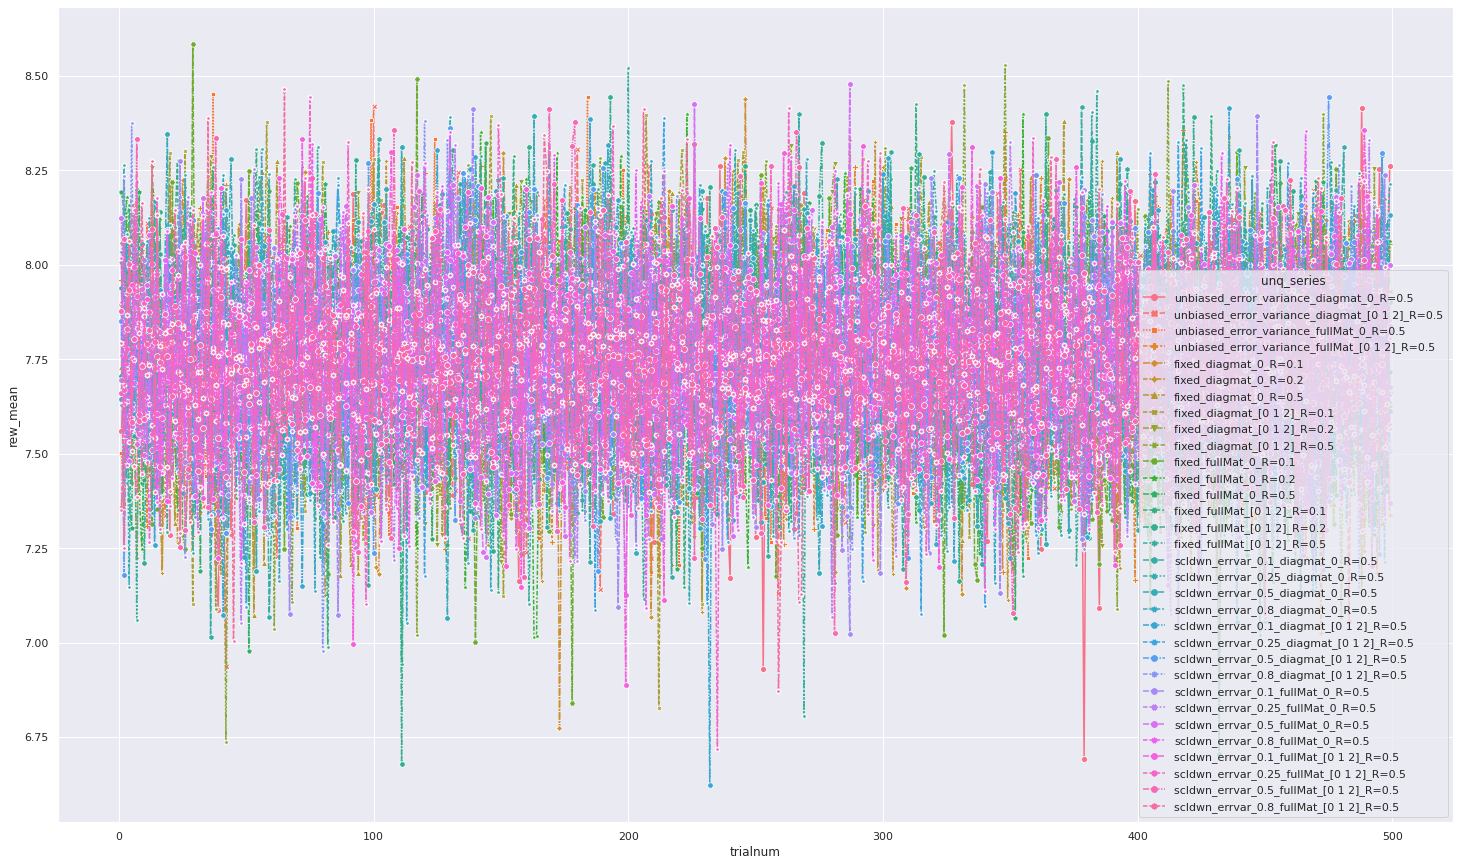

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 15))
sns.lineplot(data=allresults, x='trialnum', y='rew_mean', hue='unq_series', style='unq_series', ax=ax, markers = True, ci=None)


In [159]:
dfagg = allresults.groupby('unq_series').agg({'rew_mean':['mean', 'median', 'std'], 'rew_std':['mean']}).reset_index()
dfagg.columns = [tpl[0] + '_' + tpl[1] for tpl in dfagg.columns]
dfagg.sort_values(by='rew_mean_mean', ascending=False)

,unq_series_,rew_mean_mean,rew_mean_median,rew_mean_std,rew_std_mean
9,fixed_fullMat_[0 1 2]_R=0.1,7.77,7.77,0.23,0.68
16,scldwn_errvar_0.25_diagmat_0_R=0.5,7.76,7.76,0.22,0.69
24,scldwn_errvar_0.8_diagmat_0_R=0.5,7.76,7.77,0.22,0.68
12,scldwn_errvar_0.1_diagmat_0_R=0.5,7.76,7.76,0.22,0.69
8,fixed_fullMat_0_R=0.5,7.76,7.78,0.22,0.66
26,scldwn_errvar_0.8_fullMat_0_R=0.5,7.76,7.75,0.23,0.68
21,scldwn_errvar_0.5_diagmat_[0 1 2]_R=0.5,7.76,7.76,0.22,0.67
3,fixed_diagmat_[0 1 2]_R=0.1,7.76,7.75,0.22,0.67
31,unbiased_error_variance_fullMat_[0 1 2]_R=0.5,7.76,7.75,0.22,0.67
17,scldwn_errvar_0.25_diagmat_[0 1 2]_R=0.5,7.76,7.76,0.23,0.67


In [162]:
allresults.head()

,arm_n_0,arm_n_1,arm_n_2,arm_n_3,arm_n_4,rew_mean,rew_std,sigmultiplier,trialnum,R,scale_down_err_var,knownfeatures,unq_series
0,293,473,232,436,8566,7.56,0.39,unbiased_error_variance_diagmat,1,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,484,110,94,977,8335,7.70,0.61,unbiased_error_variance_diagmat,2,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,346,177,533,194,8750,7.63,0.54,unbiased_error_variance_diagmat,3,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,539,152,107,377,8825,7.71,0.61,unbiased_error_variance_diagmat,4,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5
0,2251,161,516,356,6716,7.59,0.49,unbiased_error_variance_diagmat,5,0.5,1,0,unbiased_error_variance_diagmat_0_R=0.5


In [165]:
d = {}
d['allresults'] = allresults
with open('./linear_contextual_bandit_TS_simulation.pkl','wb') as handle:
    pickle.dump(d, handle)